# 수면 데이터 속 시계열 데이터 실험

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, BatchNormalization, ReLU, Add, Dense, GlobalAveragePooling1D, Dropout, concatenate, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Masking
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau



In [2]:
train_sleep_df = pd.read_csv('/Users/ijonghyeon/Desktop/대학/수업/전공/3학년/2학기/데이터 마이닝/팀프로젝트/128.치매 고위험군 라이프로그/01.데이터/1.Training/원천데이터/2.수면/train_sleep.csv')
train_label_df = pd.read_csv('/Users/ijonghyeon/Desktop/대학/수업/전공/3학년/2학기/데이터 마이닝/팀프로젝트/128.치매 고위험군 라이프로그/01.데이터/1.Training/라벨링데이터/2.수면/training_label.csv')
test_sleep_df = pd.read_csv('/Users/ijonghyeon/Desktop/대학/수업/전공/3학년/2학기/데이터 마이닝/팀프로젝트/128.치매 고위험군 라이프로그/01.데이터/2.Validation/원천데이터/2.수면/val_sleep.csv')
test_label_df = pd.read_csv('/Users/ijonghyeon/Desktop/대학/수업/전공/3학년/2학기/데이터 마이닝/팀프로젝트/128.치매 고위험군 라이프로그/01.데이터/2.Validation/라벨링데이터/2.수면/val_label.csv')

train_label_df = train_label_df.rename(columns={'SAMPLE_EMAIL': 'EMAIL'})
test_label_df = test_label_df.rename(columns={'SAMPLE_EMAIL': 'EMAIL'})


train_df = pd.merge(train_sleep_df, train_label_df, on='EMAIL')
test_df = pd.merge(test_sleep_df, test_label_df, on='EMAIL')

X_train = train_df.drop(columns=['EMAIL', 'DIAG_NM']) 
y_train = train_df['DIAG_NM']
X_test = test_df.drop(columns=['EMAIL', 'DIAG_NM'])
y_test = test_df['DIAG_NM']

DIAG_NM
CN     5781
MCI    3353
Dem     571
Name: count, dtype: int64
DIAG_NM
CN     1956
MCI     308
Dem     214
Name: count, dtype: int64


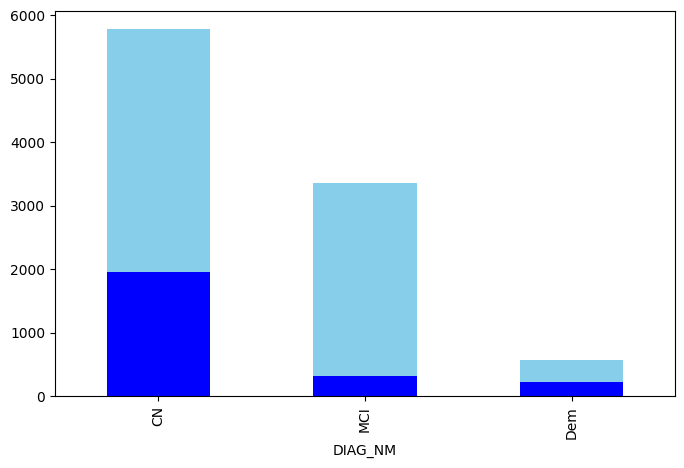

In [3]:
label_counts = train_df['DIAG_NM'].value_counts()
label_count = test_df['DIAG_NM'].value_counts()

print(label_counts)
print(label_count)


plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='skyblue')
label_count.plot(kind='bar', color='blue')
plt.show()

In [6]:
sleep_df = pd.read_csv('128.치매 고위험군 라이프로그/01.데이터/1.Training/원천데이터/2.수면/train_sleep.csv')
label_df = pd.read_csv('128.치매 고위험군 라이프로그/01.데이터/1.Training/라벨링데이터/2.수면/training_label.csv')

label_df = label_df.rename(columns={'SAMPLE_EMAIL': 'EMAIL'})
merged_df = pd.merge(sleep_df, label_df, on='EMAIL', how='inner')

merged_df['sleep_hr_5min'] = merged_df['CONVERT(sleep_hr_5min USING utf8)'].apply(
    lambda x: [int(i) if i.isdigit() else 0 for i in x.split('/')]
)
merged_df['sleep_hypnogram_5min'] = merged_df['CONVERT(sleep_hypnogram_5min USING utf8)'].apply(
    lambda x: [int(i) if i.isdigit() else 0 for i in x.split('/')]
)
merged_df['sleep_rmssd_5min'] = merged_df['CONVERT(sleep_rmssd_5min USING utf8)'].apply(
    lambda x: [int(i) if i.isdigit() else 0 for i in x.split('/')]
)

scaler = MinMaxScaler()

for col in ['sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min']:
    expanded_df = merged_df.explode(col)
    expanded_df[col] = expanded_df[col].astype(float)
    expanded_df[col] = scaler.fit_transform(expanded_df[[col]])
    merged_df[col] = expanded_df.groupby(level=0)[col].apply(list)

In [7]:
# 선형 보간 및 최인접값으로 0 값을 처리하는 함수 정의
def interpolate_and_fill_zeros(hr_list):
    hr_array = np.array(hr_list, dtype=float)
    zero_indices = np.where(hr_array == 0)[0] 
    
    start_idx = None
    for idx in zero_indices:
        if start_idx is None:
            start_idx = idx 
        if idx + 1 not in zero_indices: 
            end_idx = idx
            
            if start_idx == 0 and end_idx < len(hr_array) - 1:
                hr_array[start_idx:end_idx + 1] = hr_array[end_idx + 1]
            
            elif end_idx == len(hr_array) - 1 and start_idx > 0:
                hr_array[start_idx:end_idx + 1] = hr_array[start_idx - 1]
            
            elif start_idx > 0 and end_idx < len(hr_array) - 1:
                if hr_array[start_idx - 1] != 0 and hr_array[end_idx + 1] != 0:
                    start_val = hr_array[start_idx - 1]
                    end_val = hr_array[end_idx + 1]
                    step = (end_val - start_val) / (end_idx - start_idx + 2)
                    
                    for i in range(start_idx, end_idx + 1):
                        hr_array[i] = start_val + step * (i - start_idx + 1)
            
          
            start_idx = None
    return hr_array

merged_df['sleep_hr_5min'] = merged_df['sleep_hr_5min'].apply(interpolate_and_fill_zeros)
merged_df['sleep_rmssd_5min'] = merged_df['sleep_rmssd_5min'].apply(interpolate_and_fill_zeros)

In [8]:
merged_df['sleep_bedtime_start'] = pd.to_datetime(merged_df['sleep_bedtime_start'])
merged_df['date'] = merged_df['sleep_bedtime_start'].dt.date
merged_df = merged_df.sort_values(['EMAIL', 'date']).reset_index(drop=True)
merged_df.set_index(['EMAIL', 'date'], inplace=True)

cn_df = merged_df[merged_df['DIAG_NM'] == 'CN'].drop(columns=['DIAG_NM'])
mci_df = merged_df[merged_df['DIAG_NM'] == 'MCI'].drop(columns=['DIAG_NM'])
dem_df = merged_df[merged_df['DIAG_NM'] == 'Dem'].drop(columns=['DIAG_NM'])

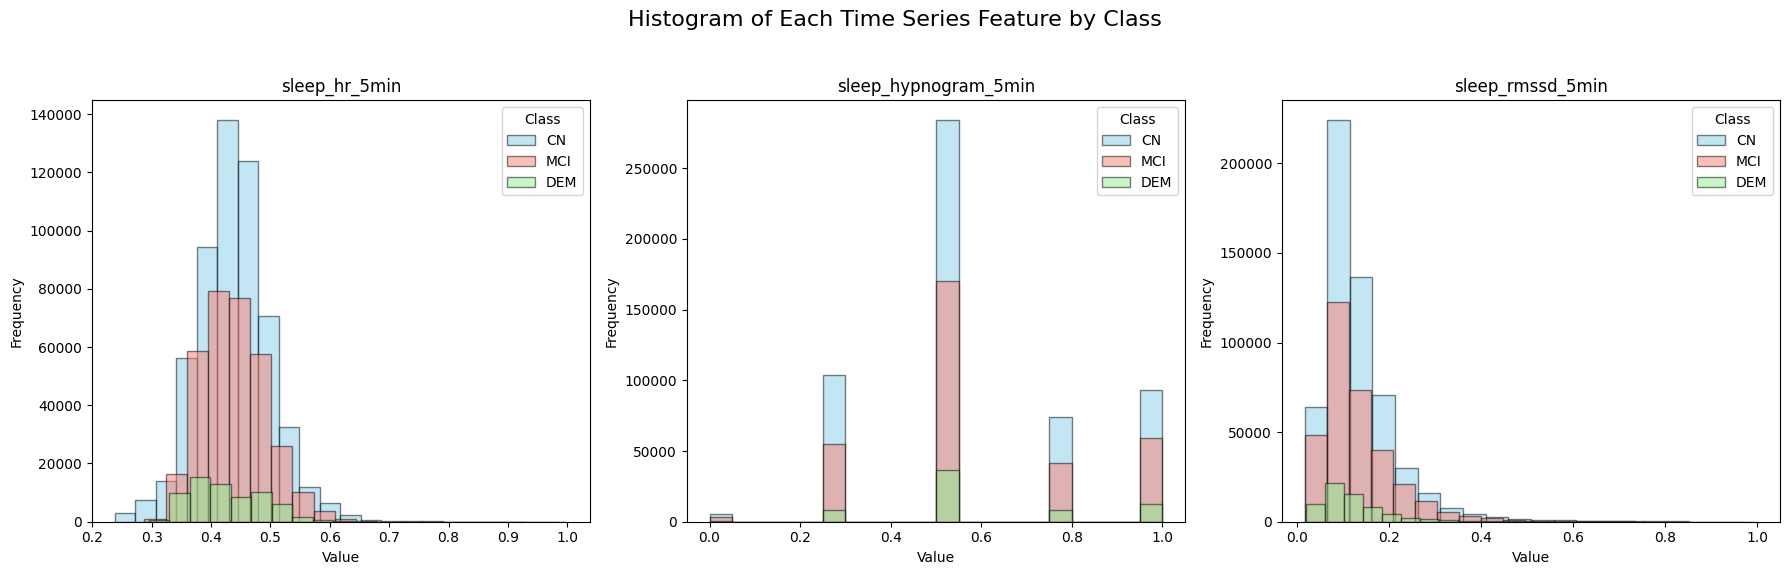

In [20]:
features = ['sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min']
class_dfs = {'CN': cn_df, 'MCI': mci_df, 'DEM': dem_df}
colors = {'CN': 'skyblue', 'MCI': 'salmon', 'DEM': 'lightgreen'}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Histogram of Each Time Series Feature by Class", fontsize=16)

for i, feature in enumerate(features):
    for class_name, df in class_dfs.items():
        data_flat = np.hstack(df[feature].values)
        axes[i].hist(data_flat, bins=20, color=colors[class_name], edgecolor='black', alpha=0.5, label=class_name)
    
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend(title="Class")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [10]:
merged_df

sleep_awake          sleep_bedtime_end  \
EMAIL            date                                                 
nia+003@rowan.kr 2020-10-18         4350  2020-10-18T06:53:31+09:00   
                 2020-10-18         5880  2020-10-19T06:46:31+09:00   
                 2020-10-23         2970  2020-10-23T06:57:03+09:00   
                 2020-10-24         6630  2020-10-25T07:36:13+09:00   
                 2020-10-28         3600  2020-10-28T08:01:40+09:00   
...                                  ...                        ...   
nia+475@rowan.kr 2021-01-12         3570  2021-01-13T08:11:25+09:00   
                 2021-01-15         5190  2021-01-15T09:23:13+09:00   
                 2021-01-15         2730  2021-01-16T05:14:29+09:00   
                 2021-01-17         3240  2021-01-18T03:39:30+09:00   
                 2021-01-19         2820  2021-01-19T08:06:06+09:00   

                                  sleep_bedtime_start  sleep_breath_average  \
EMAIL            date                                                         
nia+003@rowan.kr 2020-10-18 2020-10-18 00:22:31+09:00                17.625   
                 2020-10-18 2020-10-18 23:01:31+09:00                16.625   
                 2020-10-23 2020-10-23 00:41:03+09:00                16.500   
                 2020-10-24 2020-10-24 23:11:13+09:00                17.500   
                 2020-10-28 2020-10-28 00:09:40+09:00                16.500   
...                                               ...                   ...   
nia+475@rowan.kr 2021-01-12 2021-01-12 22:46:25+09:00                16.500   
                 2021-01-15 2021-01-15 00:55:13+09:00                15.500   
                 2021-01-15 2021-01-15 22:58:29+09:00                14.625   
                 2021-01-17 2021-01-17 23:27:30+09:00                15.000   
                 2021-01-19 2021-01-19 04:01:06+09:00                16.125   

                             sleep_deep  sleep_duration  sleep_efficiency  \
EMAIL            date                                                       
nia+003@rowan.kr 2020-10-18        6060           23460                81   
                 2020-10-18        9240           27900                79   
                 2020-10-23        3060           22560                87   
                 2020-10-24        4710           30300                78   
                 2020-10-28        2730           28320                87   
...                                 ...             ...               ...   
nia+475@rowan.kr 2021-01-12        9750           33900                89   
                 2021-01-15        8460           30480                83   
                 2021-01-15        7980           22560                88   
                 2021-01-17        4980           15120                79   
                 2021-01-19        6270           14700                81   

                                                                 sleep_hr_5min  \
EMAIL            date                                                            
nia+003@rowan.kr 2020-10-18  [0.4172661870503597, 0.4172661870503597, 0.424...   
                 2020-10-18  [0.40287769784172667, 0.40287769784172667, 0.4...   
                 2020-10-23  [0.45323741007194246, 0.45323741007194246, 0.4...   
                 2020-10-24  [0.4676258992805756, 0.4676258992805756, 0.467...   
                 2020-10-28  [0.4388489208633094, 0.4388489208633094, 0.431...   
...                                                                        ...   
nia+475@rowan.kr 2021-01-12  [0.4460431654676259, 0.4460431654676259, 0.446...   
                 2021-01-15  [0.40287769784172667, 0.40287769784172667, 0.4...   
                 2021-01-15  [0.38848920863309355, 0.38848920863309355, 0.3...   
                 2021-01-17  [0.4172661870503597, 0.4172661870503597, 0.417...   
                 2021-01-19  [0.4388489208633094, 0.4388489208633094, 0.438...   

        

In [11]:
merged_df.isnull().sum()

sleep_awake                                 0
sleep_bedtime_end                           0
sleep_bedtime_start                         0
sleep_breath_average                        0
sleep_deep                                  0
sleep_duration                              0
sleep_efficiency                            0
sleep_hr_5min                               0
sleep_hr_average                            0
sleep_hr_lowest                             0
sleep_hypnogram_5min                        0
sleep_is_longest                            0
sleep_light                                 0
sleep_midpoint_at_delta                     0
sleep_midpoint_time                         0
sleep_onset_latency                         0
sleep_period_id                             0
sleep_rem                                   0
sleep_restless                              0
sleep_rmssd                                 0
sleep_rmssd_5min                            0
sleep_score                       

In [12]:
list_1 = ['sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min', 'DIAG_NM']
series_df = merged_df[list_1]

In [13]:
series_df

sleep_hr_5min  \
EMAIL            date                                                            
nia+003@rowan.kr 2020-10-18  [0.4172661870503597, 0.4172661870503597, 0.424...   
                 2020-10-18  [0.40287769784172667, 0.40287769784172667, 0.4...   
                 2020-10-23  [0.45323741007194246, 0.45323741007194246, 0.4...   
                 2020-10-24  [0.4676258992805756, 0.4676258992805756, 0.467...   
                 2020-10-28  [0.4388489208633094, 0.4388489208633094, 0.431...   
...                                                                        ...   
nia+475@rowan.kr 2021-01-12  [0.4460431654676259, 0.4460431654676259, 0.446...   
                 2021-01-15  [0.40287769784172667, 0.40287769784172667, 0.4...   
                 2021-01-15  [0.38848920863309355, 0.38848920863309355, 0.3...   
                 2021-01-17  [0.4172661870503597, 0.4172661870503597, 0.417...   
                 2021-01-19  [0.4388489208633094, 0.4388489208633094, 0.438...   

                                                          sleep_hypnogram_5min  \
EMAIL            date                                                            
nia+003@rowan.kr 2020-10-18  [1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25...   
                 2020-10-18  [1.0, 1.0, 1.0, 1.0, 0.25, 0.25, 0.25, 0.25, 0...   
                 2020-10-23  [1.0, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0...   
                 2020-10-24  [1.0, 1.0, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0...   
                 2020-10-28  [1.0, 0.5, 1.0, 1.0, 0.5, 0.5, 0.25, 0.25, 0.2...   
...                                                                        ...   
nia+475@rowan.kr 2021-01-12  [1.0, 1.0, 1.0, 1.0, 0.25, 0.25, 0.25, 0.25, 0...   
                 2021-01-15  [1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...   
                 2021-01-15  [1.0, 1.0, 1.0, 1.0, 0.25, 0.25, 0.25, 0.5, 0....   
                 2021-01-17  [1.0, 1.0, 1.0, 1.0, 0.25, 0.25, 0.25, 0.25, 0...   
                 2021-01-19  [1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0, ...   

                                                              sleep_rmssd_5min  \
EMAIL            date                                                            
nia+003@rowan.kr 2020-10-18  [0.16470588235294117, 0.16470588235294117, 0.0...   
                 2020-10-18  [0.07450980392156863, 0.07450980392156863, 0.0...   
                 2020-10-23  [0.12549019607843137, 0.12549019607843137, 0.1...   
                 2020-10-24  [0.16078431372549018, 0.16078431372549018, 0.1...   
                 2020-10-28  [0.07450980392156863, 0.07450980392156863, 0.1...   
...                                                                        ...   
nia+475@rowan.kr 2021-01-12  [0.09803921568627451, 0.09803921568627451, 0.0...   
                 2021-01-15  [0.15294117647058825, 0.15294117647058825, 0.1...   
                 2021-01-15  [0.21568627450980393, 0.21568627450980393, 0.2...   
                 2021-01-17  [0.0784313725490196, 0.0784313725490196, 0.078...   
                 2021-01-19  [0.08235294117647059, 0.08235294117647059, 0.0...   

                            DIAG_NM  
EMAIL            date                
nia+003@rowan.kr 2020-10-18     MCI  
                 2020-10-18     MCI  
                 2020-10-23     MCI  
                 2020-10-24     MCI  
                 2020-10-28     MCI  
...                             ...  
nia+475@rowan.kr 2021-01-12      CN  
                 2021-01-15      CN  
                 2021-01-15      CN  
                 2021-01-17      CN  
                 2021-01-19      CN  

[9705 rows x 4 columns]

In [14]:
length_analysis = series_df[['sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min']].applymap(len)

length_summary = length_analysis.describe()

print("Length Analysis Summary for Each Feature:\n", length_summary)

Length Analysis Summary for Each Feature:
        sleep_hr_5min  sleep_hypnogram_5min  sleep_rmssd_5min
count    9705.000000           9705.000000       9705.000000
mean       98.646162             98.442658         98.646162
std        23.672402             23.647684         23.672402
min        38.000000             37.000000         38.000000
25%        83.000000             83.000000         83.000000
50%        98.000000             97.000000         98.000000
75%       113.000000            113.000000        113.000000
max       182.000000            181.000000        182.000000


/var/folders/l4/509zfk3j4yxfbd67y460c46c0000gn/T/ipykernel_52615/4015789357.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  length_analysis = series_df[['sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min']].applymap(len)


In [15]:
target_length = 182

hr_data = []
hypnogram_data = []
rmssd_data = []

for (email, date, DIAG_NM), group in merged_df.groupby(['EMAIL', 'date', 'DIAG_NM']):
    hr_values = list(group['sleep_hr_5min'].iloc[0]) 
    if len(hr_values) < target_length:
        hr_values.extend([0] * (target_length - len(hr_values))) 
    elif len(hr_values) > target_length:
        hr_values = hr_values[:target_length]  
    
   
    hypnogram_values = list(group['sleep_hypnogram_5min'].iloc[0])
    if len(hypnogram_values) < target_length:
        hypnogram_values.extend([0] * (target_length - len(hypnogram_values)))
    elif len(hypnogram_values) > target_length:
        hypnogram_values = hypnogram_values[:target_length]
    
    rmssd_values = list(group['sleep_rmssd_5min'].iloc[0])
    if len(rmssd_values) < target_length:
        rmssd_values.extend([0] * (target_length - len(rmssd_values)))
    elif len(rmssd_values) > target_length:
        rmssd_values = rmssd_values[:target_length]
    
    hr_data.append([email, date, DIAG_NM] + hr_values)
    hypnogram_data.append([email, date, DIAG_NM] + hypnogram_values)
    rmssd_data.append([email, date, DIAG_NM] + rmssd_values)

hr_df = pd.DataFrame(hr_data, columns=['EMAIL', 'date', 'DIAG_NM'] + [f'hr_t{i}' for i in range(1, target_length + 1)])
hypnogram_df = pd.DataFrame(hypnogram_data, columns=['EMAIL', 'date', 'DIAG_NM'] + [f'hypnogram_t{i}' for i in range(1, target_length + 1)])
rmssd_df = pd.DataFrame(rmssd_data, columns=['EMAIL', 'date', 'DIAG_NM'] + [f'rmssd_t{i}' for i in range(1, target_length + 1)])


In [16]:
hr_df

,EMAIL,date,DIAG_NM,hr_t1,hr_t2,hr_t3,hr_t4,hr_t5,hr_t6,hr_t7,...,hr_t173,hr_t174,hr_t175,hr_t176,hr_t177,hr_t178,hr_t179,hr_t180,hr_t181,hr_t182
0,nia+003@rowan.kr,2020-10-18,MCI,0.417266,0.417266,0.424460,0.417266,0.417266,0.431655,0.424460,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,nia+003@rowan.kr,2020-10-23,MCI,0.453237,0.453237,0.438849,0.438849,0.431655,0.424460,0.424460,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,nia+003@rowan.kr,2020-10-24,MCI,0.467626,0.467626,0.467626,0.467626,0.467626,0.467626,0.467626,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,nia+003@rowan.kr,2020-10-28,MCI,0.438849,0.438849,0.431655,0.438849,0.438849,0.431655,0.431655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,nia+003@rowan.kr,2020-10-29,MCI,0.453237,0.453237,0.453237,0.453237,0.446043,0.438849,0.438849,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8895,nia+475@rowan.kr,2021-01-11,CN,0.381295,0.381295,0.381295,0.381295,0.381295,0.395683,0.410072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8896,nia+475@rowan.kr,2021-01-12,CN,0.388489,0.388489,0.388489,0.388489,0.388489,0.388489,0.388489,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8897,nia+475@rowan.kr,2021-01-15,CN,0.402878,0.402878,0.402878,0.402878,0.395683,0.395683,0.402878,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8898,nia+475@rowan.kr,2021-01-17,CN,0.417266,0.417266,0.417266,0.417266,0.417266,0.417266,0.417266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
y = hr_df['DIAG_NM'].values

X_hr = hr_df.iloc[:, 3:].values 
X_hypnogram = hypnogram_df.iloc[:, 3:].values 
X_rmssd = rmssd_df.iloc[:, 3:].values 

X_hr = X_hr[:, :, np.newaxis]  
X_hypnogram = X_hypnogram[:, :, np.newaxis]  
X_rmssd = X_rmssd[:, :, np.newaxis] 

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) 
y_onehot = to_categorical(y_encoded)

X_hr_train, X_hr_test, y_train, y_test = train_test_split(X_hr, y_onehot, test_size=0.2, random_state=42)
X_hypnogram_train, X_hypnogram_test = train_test_split(X_hypnogram, test_size=0.2, random_state=42)
X_rmssd_train, X_rmssd_test = train_test_split(X_rmssd, test_size=0.2, random_state=42)

In [ ]:
input_hr = Input(shape=(182, 1), name='input_hr')
masked_hr = Masking(mask_value=0.0)(input_hr)
x1 = Bidirectional(LSTM(128, return_sequences=True))(masked_hr)
x1 = Dropout(0.3)(x1)
x1 = BatchNormalization()(x1)
x1 = Bidirectional(LSTM(64, return_sequences=False))(x1)
x1 = Dropout(0.3)(x1)

input_hypnogram = Input(shape=(182, 1), name='input_hypnogram')
masked_hypnogram = Masking(mask_value=0.0)(input_hypnogram)
x2 = Bidirectional(LSTM(128, return_sequences=True))(masked_hypnogram)
x2 = Dropout(0.3)(x2)
x2 = BatchNormalization()(x2)
x2 = Bidirectional(LSTM(64, return_sequences=False))(x2)
x2 = Dropout(0.3)(x2)

input_rmssd = Input(shape=(182, 1), name='input_rmssd')
masked_rmssd = Masking(mask_value=0.0)(input_rmssd)
x3 = Bidirectional(LSTM(128, return_sequences=True))(masked_rmssd)
x3 = Dropout(0.3)(x3)
x3 = BatchNormalization()(x3)
x3 = Bidirectional(LSTM(64, return_sequences=False))(x3)
x3 = Dropout(0.3)(x3)

merged = concatenate([x1, x2, x3])

merged = Dense(128, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = Dropout(0.4)(merged)
merged = Dense(64, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = Dropout(0.4)(merged)

output = Dense(len(label_encoder.classes_), activation='softmax')(merged)

ensemble_model = Model(inputs=[input_hr, input_hypnogram, input_rmssd], outputs=output)

ensemble_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

history = ensemble_model.fit(
    [X_hr_train, X_hypnogram_train, X_rmssd_train], y_train,
    validation_split=0.2, epochs=50, batch_size=64,
    callbacks=[lr_scheduler]
)

print("Improved Ensemble Model Training Completed")

Epoch 1/50


/opt/anaconda3/envs/for_tf/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_hr', 'input_hypnogram', 'input_rmssd']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


89/89 ━━━━━━━━━━━━━━━━━━━━ 52s 517ms/step - accuracy: 0.3670 - loss: 1.6668 - val_accuracy: 0.6124 - val_loss: 0.9151 - learning_rate: 0.0010
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 45s 501ms/step - accuracy: 0.4319 - loss: 1.2253 - val_accuracy: 0.6145 - val_loss: 0.8877 - learning_rate: 0.0010
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 45s 505ms/step - accuracy: 0.4993 - loss: 1.0464 - val_accuracy: 0.6124 - val_loss: 0.8715 - learning_rate: 0.0010
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 45s 510ms/step - accuracy: 0.4969 - loss: 0.9854 - val_accuracy: 0.6124 - val_loss: 0.8662 - learning_rate: 0.0010
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 46s 514ms/step - accuracy: 0.5333 - loss: 0.9195 - val_accuracy: 0.6124 - val_loss: 0.8559 - learning_rate: 0.0010
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 49s 548ms/step - accuracy: 0.5348 - loss: 0.9048 - val_accuracy: 0.6124 - val_loss: 0.8425 - learning_rate: 0.0010
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 51s 571ms/step - accuracy: 0.5762 - loss: 0.8980 - val_

KeyboardInterrupt: 

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


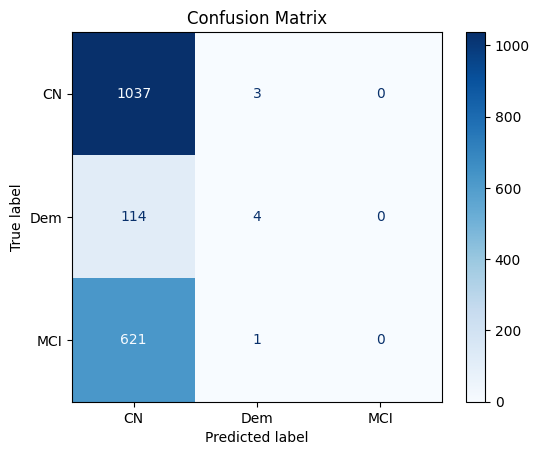

In [19]:
# 1. 모델 예측
y_pred = ensemble_model.predict([X_hr_test, X_hypnogram_test, X_rmssd_test])  # 예측 확률
y_pred_classes = np.argmax(y_pred, axis=1)  # 확률을 클래스 인덱스로 변환
y_true = np.argmax(y_test, axis=1)  # 실제 클래스 (원핫인코딩을 역변환)

# 2. Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred_classes)

# 3. Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(f"X_train dtype: {X_train.dtype}")
print(f"y_train dtype: {y_train.dtype}")
print(f"First few samples in X_train: {X_train[:5]}")
print(f"First few samples in y_train: {y_train[:5]}")

In [ ]:

def residual_block(x, filters, kernel_size, stride):
    shortcut = x  
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x


def multi_scale_residual_block(x, filters):
    shortcut = x  
    x1 = Conv1D(filters, kernel_size=3, strides=1, padding='same')(x)
    x2 = Conv1D(filters, kernel_size=5, strides=1, padding='same')(x)
    x3 = Conv1D(filters, kernel_size=7, strides=1, padding='same')(x)
    x = concatenate([x1, x2, x3])
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])  
    x = ReLU()(x)
    return x

def build_advanced_resnet(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, strides=1, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    for _ in range(3):
        x = residual_block(x, 64, kernel_size=3, stride=1)
    for _ in range(3):
        x = multi_scale_residual_block(x, 64) 
    
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.4)(x)
    return input_layer, x


input_hr, x1 = build_advanced_resnet((182, 1))
input_hypnogram, x2 = build_advanced_resnet((182, 1))
input_rmssd, x3 = build_advanced_resnet((182, 1))

merged = concatenate([x1, x2, x3])
merged = Dense(256, activation='relu')(merged) 
merged = Dropout(0.4)(merged) 
merged = Dense(128, activation='relu')(merged)
merged = Dropout(0.4)(merged)
output = Dense(len(label_encoder.classes_), activation='softmax')(merged)

advanced_resnet_model = Model(inputs=[input_hr, input_hypnogram, input_rmssd], outputs=output)

advanced_resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=7,       
    restore_best_weights=True 
)

def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.99 

lr_callback = LearningRateScheduler(lr_scheduler)

history = advanced_resnet_model.fit(
    [X_hr_train, X_hypnogram_train, X_rmssd_train], y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[lr_callback, early_stopping] 
)

print("Advanced ResNet Model Training Completed")

Epoch 1/50


/opt/anaconda3/envs/for_tf/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_25', 'keras_tensor_82', 'keras_tensor_139']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


89/89 ━━━━━━━━━━━━━━━━━━━━ 38s 216ms/step - accuracy: 0.5004 - loss: 1.1757 - val_accuracy: 0.5997 - val_loss: 0.9040 - learning_rate: 0.0010
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - accuracy: 0.5547 - loss: 0.8700 - val_accuracy: 0.6124 - val_loss: 0.8114 - learning_rate: 0.0010
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - accuracy: 0.5786 - loss: 0.8556 - val_accuracy: 0.6131 - val_loss: 0.8226 - learning_rate: 0.0010
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - accuracy: 0.5788 - loss: 0.8325 - val_accuracy: 0.6152 - val_loss: 0.8009 - learning_rate: 0.0010
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - accuracy: 0.5739 - loss: 0.8330 - val_accuracy: 0.6131 - val_loss: 0.7988 - learning_rate: 0.0010
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - accuracy: 0.5857 - loss: 0.8263 - val_accuracy: 0.5969 - val_loss: 0.8436 - learning_rate: 0.0010
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - accuracy: 0.5728 - loss: 0.8173 - val_

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5729 - loss: 0.8390
Test Loss: 0.815473735332489
Test Accuracy: 0.5926966071128845
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


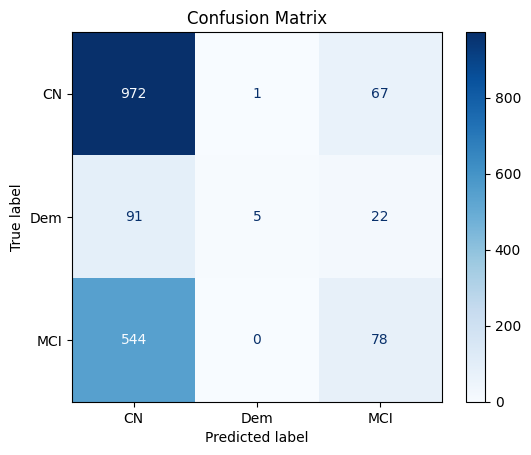

In [20]:
test_loss, test_accuracy = advanced_resnet_model.evaluate(
    [X_hr_test, X_hypnogram_test, X_rmssd_test], y_test
)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


y_pred = advanced_resnet_model.predict([X_hr_test, X_hypnogram_test, X_rmssd_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Label prediction using by FFT

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA

### 1. 전처리

In [ ]:
def linear_interpolation(arr):
    arr = np.array(arr, dtype=float)
    zero_indices = np.where(arr == 0)[0]
    
    for idx in zero_indices:
        start = idx
        while idx < len(arr) and arr[idx] == 0:
            idx += 1
        end = idx
        
        if start > 0 and end < len(arr):
            start_val = arr[start - 1]
            end_val = arr[end]
            step = (end_val - start_val) / (end - start + 1)
            for i in range(start, end):
                arr[i] = start_val + step * (i - start + 1)
        elif start == 0 and end < len(arr):
            arr[start:end] = arr[end]
        elif start > 0 and end == len(arr):
            arr[start:end] = arr[start - 1]
    
    return np.round(arr).astype(int)

def hypnogram_fill(arr):
    arr = np.array(arr, dtype=int)
    zero_indices = np.where(arr == 0)[0]
    
    start_idx = None
    for idx in zero_indices:
        if start_idx is None:
            start_idx = idx
        if idx + 1 not in zero_indices:
            end_idx = idx
            
            if start_idx == 0:
                arr[start_idx:end_idx + 1] = 4
            else:
                arr[start_idx:end_idx + 1] = arr[start_idx - 1]
            start_idx = None
    return arr

def truncate_after_5_hours(arr):
    return arr[:60] if len(arr) >= 60 else None 

def preprocess_and_filter(df):
    processed_rows = []
    
    for _, row in df.iterrows():
        hr_segment = truncate_after_5_hours(row['sleep_hr_5min'])
        hypnogram_segment = truncate_after_5_hours(row['sleep_hypnogram_5min'])
        rmssd_segment = truncate_after_5_hours(row['sleep_rmssd_5min'])
        
        if hr_segment is not None and hypnogram_segment is not None and rmssd_segment is not None:
            processed_rows.append({
                'sleep_hr_5min': linear_interpolation(hr_segment),
                'sleep_hypnogram_5min': hypnogram_fill(hypnogram_segment),
                'sleep_rmssd_5min': linear_interpolation(rmssd_segment),
                'label': row['DIAG_NM']
            })

    processed_df = pd.DataFrame(processed_rows)
    
    scaler = StandardScaler()
    processed_df['sleep_hr_5min'] = processed_df['sleep_hr_5min'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten())
    processed_df['sleep_rmssd_5min'] = processed_df['sleep_rmssd_5min'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten())
    
    return processed_df

In [ ]:
train_sleep_df = pd.read_csv('/Users/ijonghyeon/Desktop/대학/수업/전공/3학년/2학기/데이터 마이닝/팀프로젝트/128.치매 고위험군 라이프로그/01.데이터/1.Training/원천데이터/2.수면/train_sleep.csv')
train_label_df = pd.read_csv('/Users/ijonghyeon/Desktop/대학/수업/전공/3학년/2학기/데이터 마이닝/팀프로젝트/128.치매 고위험군 라이프로그/01.데이터/1.Training/라벨링데이터/2.수면/training_label.csv')
test_sleep_df = pd.read_csv('/Users/ijonghyeon/Desktop/대학/수업/전공/3학년/2학기/데이터 마이닝/팀프로젝트/128.치매 고위험군 라이프로그/01.데이터/2.Validation/원천데이터/2.수면/val_sleep.csv')
test_label_df = pd.read_csv('/Users/ijonghyeon/Desktop/대학/수업/전공/3학년/2학기/데이터 마이닝/팀프로젝트/128.치매 고위험군 라이프로그/01.데이터/2.Validation/라벨링데이터/2.수면/val_label.csv')

train_label_df = train_label_df.rename(columns={'SAMPLE_EMAIL': 'EMAIL'})
train_merged_df = pd.merge(train_sleep_df, train_label_df, on='EMAIL', how='inner')

test_label_df = test_label_df.rename(columns={'SAMPLE_EMAIL': 'EMAIL'})
test_merged_df = pd.merge(test_sleep_df, test_label_df, on='EMAIL', how='inner')

def preprocess_series(df):
    df['sleep_hr_5min'] = df['CONVERT(sleep_hr_5min USING utf8)'].apply(
        lambda x: [int(i) if i.isdigit() else 0 for i in x.split('/')]
    )
    df['sleep_hypnogram_5min'] = df['CONVERT(sleep_hypnogram_5min USING utf8)'].apply(
        lambda x: [int(i) if i.isdigit() else 0 for i in x.split('/')]
    )
    df['sleep_rmssd_5min'] = df['CONVERT(sleep_rmssd_5min USING utf8)'].apply(
        lambda x: [int(i) if i.isdigit() else 0 for i in x.split('/')]
    )
    return df

train_merged_df = preprocess_series(train_merged_df)
test_merged_df = preprocess_series(test_merged_df)

train_processed_df = preprocess_and_filter(train_merged_df)
test_processed_df = preprocess_and_filter(test_merged_df)

X_train = np.vstack(train_processed_df[['sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min']].apply(
    lambda row: np.hstack(row), axis=1
))
y_train = train_processed_df['label'].values

X_test = np.vstack(test_processed_df[['sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min']].apply(
    lambda row: np.hstack(row), axis=1
))
y_test = test_processed_df['label'].values


### 2. 모델

In [ ]:
# FFT를 통해 주파수 특성을 추출 후 선형모델 적용
def extract_fft_features(df, n_freq=5):
    feature_data = pd.DataFrame()
    
    for col in ['sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min']:
        fft_features = df[col].apply(lambda x: np.fft.fft(np.array(x)))  
        fft_amplitudes = fft_features.apply(lambda x: np.abs(x)[:n_freq]) 
        
        for i in range(n_freq):
            feature_data[f'{col}_fft_{i}'] = fft_amplitudes.apply(lambda x: x[i] if len(x) > i else 0)
    
    return feature_data

n_freq = 20

X_fft_train = extract_fft_features(train_processed_df, n_freq=n_freq)
X_fft_test = extract_fft_features(test_processed_df, n_freq=n_freq)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_fft_train, y_train)
y_pred = model.predict(X_fft_test)

print(classification_report(y_test, y_pred))

/opt/anaconda3/envs/for_tf/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

          CN       0.79      0.99      0.88      1896
         Dem       0.00      0.00      0.00       212
         MCI       0.08      0.01      0.01       299

    accuracy                           0.78      2407
   macro avg       0.29      0.33      0.30      2407
weighted avg       0.63      0.78      0.69      2407



In [ ]:
# ARIMA를 통해 시계열 예측 특성을 생성하는 함수
def extract_arima_features(series, order=(1,1,1), steps=5):
    try:
        model = ARIMA(series, order=order)
        fit = model.fit()
        forecast = fit.forecast(steps=steps) 
        return forecast
    except:
        return np.array([np.nan] * steps)

# 데이터프레임에 ARIMA를 적용하여 특징 생성
def apply_arima_to_dataframe(df, arima_order=(1,1,1), steps=5):
    arima_features = pd.DataFrame()
    
    for col in ['sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min']:
        arima_pred = df[col].apply(lambda x: extract_arima_features(x, order=arima_order, steps=steps))
        
        for i in range(steps):
            arima_features[f'{col}_arima_{i}'] = arima_pred.apply(lambda x: x[i] if len(x) > i else np.nan)
            
    return arima_features

X_arima_train = apply_arima_to_dataframe(train_processed_df, arima_order=(1,1,1), steps=5)
X_arima_test = apply_arima_to_dataframe(test_processed_df, arima_order=(1,1,1), steps=5)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_arima_train, y_train)
y_pred = model.predict(X_arima_test)

print(classification_report(y_test, y_pred))

/opt/anaconda3/envs/for_tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/for_tf/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/for_tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/for_tf/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda

              precision    recall  f1-score   support

          CN       0.79      1.00      0.88      1896
         Dem       0.00      0.00      0.00       212
         MCI       0.00      0.00      0.00       299

    accuracy                           0.79      2407
   macro avg       0.26      0.33      0.29      2407
weighted avg       0.62      0.79      0.69      2407



/opt/anaconda3/envs/for_tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/for_tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 윈도우를 이용해 특징 추출 후 선형모델 적용
def create_windows(arr, window_size):
    return [arr[i:i + window_size] for i in range(len(arr) - window_size + 1)]

def extract_features(arr, window_size=10):
    windows = create_windows(arr, window_size)
    features = []
    for window in windows:
        features.extend([
            np.mean(window),  
            np.std(window),   
            np.max(window),   
            np.min(window)   
        ])
    return np.array(features)

window_size = 10

train_features = []
for _, row in train_processed_df.iterrows():
    hr_features = extract_features(row['sleep_hr_5min'], window_size)
    hypnogram_features = extract_features(row['sleep_hypnogram_5min'], window_size)
    rmssd_features = extract_features(row['sleep_rmssd_5min'], window_size)
    all_features = np.hstack([hr_features, hypnogram_features, rmssd_features])
    train_features.append(all_features)
X_train = np.vstack(train_features)
y_train = train_processed_df['label'].values

test_features = []
for _, row in test_processed_df.iterrows():
    hr_features = extract_features(row['sleep_hr_5min'], window_size)
    hypnogram_features = extract_features(row['sleep_hypnogram_5min'], window_size)
    rmssd_features = extract_features(row['sleep_rmssd_5min'], window_size)
    all_features = np.hstack([hr_features, hypnogram_features, rmssd_features])
    test_features.append(all_features)
X_test = np.vstack(test_features)
y_test = test_processed_df['label'].values

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("정확도:", accuracy_score(y_test, y_pred))
print("분류 보고서:\n", classification_report(y_test, y_pred))

정확도: 0.6530951391773993
분류 보고서:
               precision    recall  f1-score   support

          CN       0.78      0.81      0.79      1896
         Dem       0.17      0.02      0.03       212
         MCI       0.10      0.14      0.11       299

    accuracy                           0.65      2407
   macro avg       0.35      0.32      0.31      2407
weighted avg       0.64      0.65      0.64      2407



/opt/anaconda3/envs/for_tf/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# 윈도우 + 오토리그레시브
def augment_features(X, window_sizes=[3, 6, 12], lags=5):
    augmented_features = []
    
    for sample in X:
        time_features = []
        for window in window_sizes:
            if len(sample) >= window:
                time_features.extend([
                    np.mean(sample[-window:]), 
                    np.std(sample[-window:]),   
                    sample[-1] - sample[-window] 
                ])
        
        ar_features = sample[-lags:] if len(sample) >= lags else np.pad(sample, (lags - len(sample), 0), 'constant')
        
        augmented_features.append(np.hstack([sample, time_features, ar_features]))
    
    return np.array(augmented_features)

X_train_augmented = augment_features(X_train)
X_test_augmented = augment_features(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_augmented, y_train)

y_pred = model.predict(X_test_augmented)
print("정확도:", accuracy_score(y_test, y_pred))
print("분류 보고서:\n", classification_report(y_test, y_pred))

정확도: 0.5632060247444863
분류 보고서:
               precision    recall  f1-score   support

          CN       0.61      0.80      0.69      1116
         Dem       0.23      0.09      0.13       103
         MCI       0.40      0.23      0.29       640

    accuracy                           0.56      1859
   macro avg       0.41      0.37      0.37      1859
weighted avg       0.52      0.56      0.52      1859



/opt/anaconda3/envs/for_tf/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
train_label_df = pd.read_csv('128.치매 고위험군 라이프로그/01.데이터/2.Validation/라벨링데이터/2.수면/val_label.csv')

train_label_df[train_label_df['DIAG_NM'] == 'CN'].shape[0]

26